In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
np.set_printoptions(threshold = np.nan)
def loadData():
    with np.load('notMNIST.npz') as data :
        Data, Target = data ['images'], data['labels']
        posClass = 2
        negClass = 9
        dataIndx = (Target==posClass) + (Target==negClass)
        Data = Data[dataIndx]/255.
        #print(Data[0])
        Target = Target[dataIndx].reshape(-1, 1)
        Target[Target==posClass] = 1
        Target[Target==negClass] = 0
        np.random.seed(421)
        randIndx = np.arange(len(Data))
        np.random.shuffle(randIndx)
        Data, Target = Data[randIndx], Target[randIndx]
        trainData, trainTarget = Data[:3500], Target[:3500]
        validData, validTarget = Data[3500:3600], Target[3500:3600]
        testData, testTarget = Data[3600:], Target[3600:]
    return trainData, validData, testData, trainTarget, validTarget, testTarget

In [4]:
def MSE(W, b, x, y, reg):
    loss = 0
    for i in range(0,len(y)):
        traning_data = x[i].flatten()
        loss =1/(2*len(y))*(np.dot(np.transpose(W),traning_data) + b - y[i])**2 + loss
    loss = loss + reg/2 * np.dot(np.transpose(W), W)
    #print(np.shape(W),np.shape(b),np.shape(traning_data),np.shape(y))
    return loss

In [5]:
def accuracy_MSE(W, b, x, y, reg):
    correct = 0
    for i in range(0,len(y)):
        traning_data = x[i].flatten()
        y_hat = np.dot(np.transpose(W),traning_data) + b
        if(y[i] == 0 and np.sign(y_hat)== -1):
            correct = correct +1
        elif(y[i] == 1 and np.sign(y_hat)== 1):
            correct = correct +1
    accuracy_rate = (correct/len(y))*100
    return accuracy_rate

In [6]:
def crossEntropyLoss(W, b, x, y, reg):
    loss = 0
    for i in range(0,len(y)):
        traning_data = x[i].flatten()
        y_bar = np.dot(np.transpose(W),traning_data) + b
        loss =1/(len(y))*(np.log(1 + np.exp(-y_bar)) + (1-y[i])*y_bar) + loss
    loss = loss + reg/2 * np.dot(np.transpose(W), W)
    #print(y_bar)
    return loss

In [7]:
def accuracy_CE(W, b, x, y, reg):
    correct = 0
    for i in range(0,len(y)):
        traning_data = x[i].flatten()
        sigma = 1/(1+ np.exp(-(np.dot(np.transpose(W),traning_data) + b)))
        if(y[i] == 0 and sigma <=0.5):
            correct = correct +1
        elif(y[i] == 1 and sigma >0.5):
            correct = correct +1
    accuracy_rate = (correct/len(y))*100
    #print(accuracy_rate)
    return accuracy_rate

In [61]:
def buildGraph(loss=None):
    #Initialize weight and bias tensors
    tf.set_random_seed(421)

    #Tensors to hold the bias and matrix values 
    W = tf.Variable(tf.truncated_normal(mean= 0.0, shape = (1,784), stddev = 0.5, dtype = tf.float32, name = "weight"))
    b = tf.Variable(1.0, name='biases', dtype=tf.float32)
    #print(np.shape(W),np.shape(b))
   
    #Tensors to hold the variables 
    X = tf.placeholder(tf.float32,[None, 784],name='X')
    Y = tf.placeholder(tf.float32, [None, 1], name = 'Y')
    y_e = tf.matmul(X,tf.transpose(W)) + b
    #print(np.shape(X),np.shape(Y))
    
    if loss == "MSE":
        error = tf.reduce_sum(tf.losses.mean_squared_error(labels=Y, predictions=y_e))  
    elif loss == "CE":
        predict = y_e
        y_e = tf.sigmoid(y_e)
        error = tf.reduce_sum(tf.nn.sigmoid_cross_entropy_with_logits(labels=Y,logits=predict,name=None))
        #error = tf.nn.sigmoid_cross_entropy_with_logits(labels=Y,logits=y_e,name=None)
    optimizer = tf.train.AdamOptimizer(learning_rate = 0.001,epsilon=1e-04)
    train = optimizer.minimize(loss=error)
    return W, b, X,y_e, Y, error, train

In [62]:
buildGraph("CE")

(<tf.Variable 'Variable_19:0' shape=(1, 784) dtype=float32_ref>,
 <tf.Variable 'biases_19:0' shape=() dtype=float32_ref>,
 <tf.Tensor 'X_19:0' shape=(?, 784) dtype=float32>,
 <tf.Tensor 'Sigmoid_19:0' shape=(?, 1) dtype=float32>,
 <tf.Tensor 'Y_19:0' shape=(?, 1) dtype=float32>,
 <tf.Tensor 'Sum_19:0' shape=() dtype=float32>,
 <tf.Operation 'Adam_19' type=NoOp>)

In [63]:
def acc_test(y_e,y,typeError):
    corret = 0
    if (typeError == "MSE"):
        for k in range(len(y)):
            if(np.sign(y_e[k])==y[k] or ((np.sign(y_e[k])+1) == y[k])):
                corret = corret+1
        acc = corret/len(y) * 100
        return acc
    elif (typeError == "CE"):
        for k in range(len(y)):
            if (y_e[k]>=0.5 and y[k] == 1) or (y_e[k]<0.5 and y[k]==0):
                corret = corret+1
        acc = corret/len(y) * 100
        return acc
            

In [64]:
def SGD(epochs, i_data, o_data,typeError,batch_size): 
    # Initialize session
    W, b, X, y_e, Y,error,train = buildGraph(typeError)
    init = tf.global_variables_initializer()
    #flatten input
    traning = i_data.reshape(np.shape(i_data)[0],-1)
    #print(np.shape(traning))
    with tf.Session() as sess:
        sess.run(init)
        #store
        t_Error = []
        t_Accuracy = []
        v_err = []
        v_acc = []
        t_err = []
        t_acc = []
        for i in range(epochs):#700
            instances = np.shape(i_data)[0]
            totalBatches = int(instances / batch_size)
            #print(totalBatches)----7
            x_r = np.random.permutation(len(i_data))
            #print(len(x_r))----3500 random number
            X_r, Y_r = traning[x_r], trainTarget[x_r]
            #rebuild data and target
            j = 0
            for k in range(totalBatches):#7
                X_batch = X_r[j:(j + batch_size),:]
                y_batch = Y_r[j:(j + batch_size),:]
                _, err, currentW, currentb, yhat = sess.run([train, error, W, b, y_e], feed_dict={X:X_batch, Y:y_batch})
                i = i + batch_size
                if (typeError == "CE"):
                    err = (err/batch_size)
            currentW = currentW.flatten()
            #print(np.shape(currentW),currentb)
            
            #accuracy and loss stored
            if (typeError =="MSE"):
                #a = MSE(currentW,currentb,validData,validTarget,0)
                #print(a)
                v_err.append(MSE(currentW,currentb,validData,validTarget,0))
                v_acc.append(accuracy_MSE(currentW,currentb,validData,validTarget,0))
                t_err.append(MSE(currentW,currentb,testData,testTarget,0))
                t_acc.append(accuracy_MSE(currentW,currentb,testData,testTarget,0))
            elif (typeError =="CE"):
                #v_err.append(crossEntropyLoss(currentW,currentb,validData,validTarget,0))
                v_acc.append(accuracy_CE(currentW,currentb,validData,validTarget,0))
                #t_err.append(crossEntropyLoss(currentW,currentb,testData,testTarget,0))
                t_acc.append(accuracy_CE(currentW,currentb,testData,testTarget,0))
            #training data
            acc = acc_test(yhat,y_batch,typeError)
            t_Accuracy.append(acc)
            t_Error.append(err)  
            
            #print(np.shape(err))
        #for k in range(100):
            #print(t_Error[k],t_Accuracy[k],v_err[k],v_acc[k],t_acc[k])
        return t_Error,t_Accuracy,v_err,v_acc,t_err,t_acc

In [65]:
trainData, validData, testData, trainTarget, validTarget, testTarget = loadData()

In [ ]:
t_Error,t_Accuracy,v_err,v_acc,t_err,t_acc = SGD(700,trainData,trainTarget,"MSE",500)

In [66]:
t_Error,t_Accuracy,v_err,v_acc,t_err,t_acc = SGD(700,trainData,trainTarget,"CE",500)

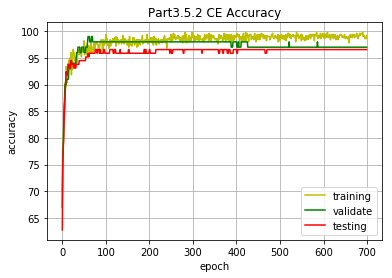

In [13]:
plt.figure(0)
plt.title("Part3.5.2 CE Accuracy")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.plot(range(len(t_Accuracy)), t_Accuracy, 'y-', label="training")
plt.plot(range(len(v_acc)), v_acc, 'g-', label="validate")
plt.plot(range(len(t_acc)), t_acc,'r-', label="testing")
plt.grid()
plt.legend()

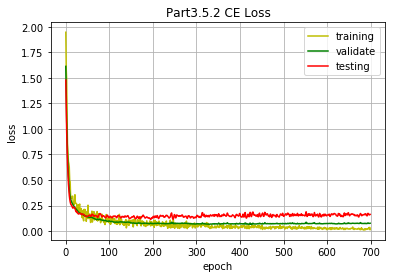

In [60]:
plt.figure(0)
plt.title("Part3.5.2 CE Loss")
plt.xlabel("epoch")

#print(t_Error)
plt.ylabel("loss")
plt.plot(range(len(t_Error)), t_Error, 'y-', label="training")
plt.plot(range(len(v_err)), v_err, 'g-', label="validate")
plt.plot(range(len(t_err)), t_err,'r-', label="testing")
plt.grid()
plt.legend()

In [22]:
t_Error_100,t_Accuracy_100 = SGD(700,trainData,trainTarget,"CE",100)
t_Error_700,t_Accuracy_700 = SGD(700,trainData,trainTarget,"CE",700)
t_Error_1750,t_Accuracy_1750 = SGD(700,trainData,trainTarget,"CE",1750)

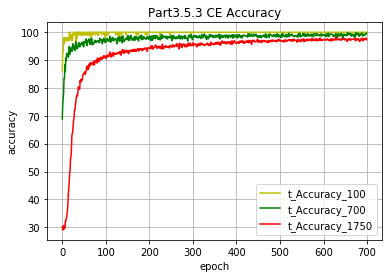

In [18]:
plt.figure(0)
plt.title("Part3.5.3 CE Accuracy")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.plot(range(len(t_Accuracy_100)), t_Accuracy_100, 'y-', label="t_Accuracy_100")
plt.plot(range(len(t_Accuracy_700)), t_Accuracy_700, 'g-', label="t_Accuracy_700")
plt.plot(range(len(t_Accuracy_1750)), t_Accuracy_1750,'r-', label="t_Accuracy_1750")
plt.grid()
plt.legend()

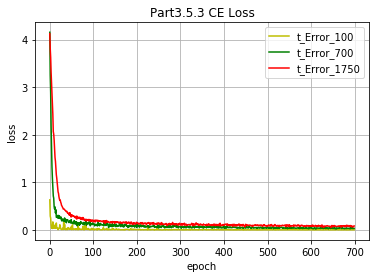

In [23]:
plt.figure(0)
plt.title("Part3.5.3 CE Loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.plot(range(len(t_Error_100)), t_Error_100, 'y-', label="t_Error_100")
plt.plot(range(len(t_Error_700)), t_Error_700, 'g-', label="t_Error_700")
plt.plot(range(len(t_Error_1750)), t_Error_1750,'r-', label="t_Error_1750")
plt.grid()
plt.legend()

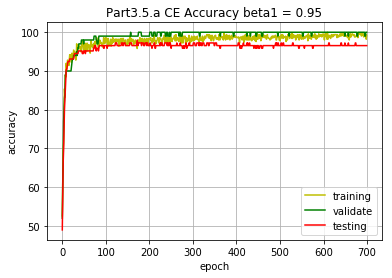

In [32]:
plt.figure(0)
plt.title("Part3.5.a CE Accuracy beta1 = 0.95")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.plot(range(len(t_Accuracy)), t_Accuracy, 'y-', label="training")
plt.plot(range(len(v_acc)), v_acc, 'g-', label="validate")
plt.plot(range(len(t_acc)), t_acc,'r-', label="testing")
plt.grid()
plt.legend()

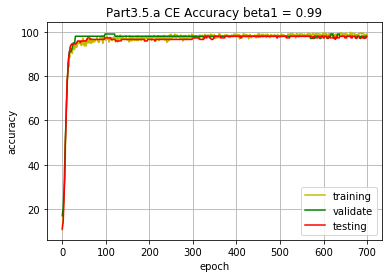

In [39]:
plt.figure(0)
plt.title("Part3.5.a CE Accuracy beta1 = 0.99")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.plot(range(len(t_Accuracy)), t_Accuracy, 'y-', label="training")
plt.plot(range(len(v_acc)), v_acc, 'g-', label="validate")
plt.plot(range(len(t_acc)), t_acc,'r-', label="testing")
plt.grid()
plt.legend()

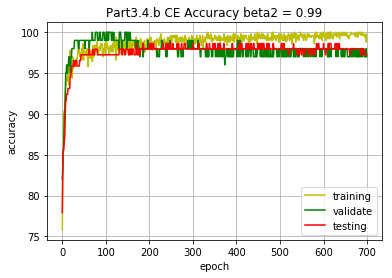

In [46]:
plt.figure(0)
plt.title("Part3.4.b CE Accuracy beta2 = 0.99")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.plot(range(len(t_Accuracy)), t_Accuracy, 'y-', label="training")
plt.plot(range(len(v_acc)), v_acc, 'g-', label="validate")
plt.plot(range(len(t_acc)), t_acc,'r-', label="testing")
plt.grid()
plt.legend()

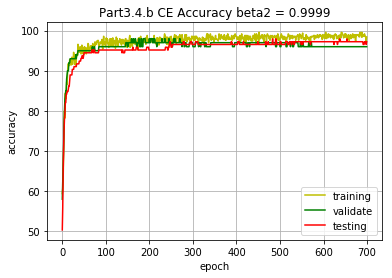

In [53]:
plt.figure(0)
plt.title("Part3.4.b CE Accuracy beta2 = 0.9999")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.plot(range(len(t_Accuracy)), t_Accuracy, 'y-', label="training")
plt.plot(range(len(v_acc)), v_acc, 'g-', label="validate")
plt.plot(range(len(t_acc)), t_acc,'r-', label="testing")
plt.grid()
plt.legend()

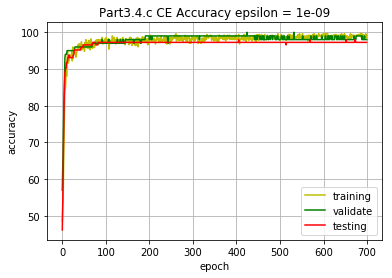

In [60]:
plt.figure(0)
plt.title("Part3.4.c CE Accuracy epsilon = 1e-09")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.plot(range(len(t_Accuracy)), t_Accuracy, 'y-', label="training")
plt.plot(range(len(v_acc)), v_acc, 'g-', label="validate")
plt.plot(range(len(t_acc)), t_acc,'r-', label="testing")
plt.grid()
plt.legend()

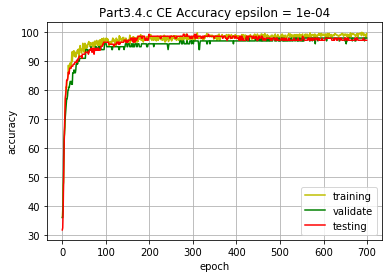

In [67]:
plt.figure(0)
plt.title("Part3.4.c CE Accuracy epsilon = 1e-04")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.plot(range(len(t_Accuracy)), t_Accuracy, 'y-', label="training")
plt.plot(range(len(v_acc)), v_acc, 'g-', label="validate")
plt.plot(range(len(t_acc)), t_acc,'r-', label="testing")
plt.grid()
plt.legend()